In [1]:
!python -V

Python 3.7.6


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import pickle

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')

In [6]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


### Question 1: Number of records in Jan 2021 FHV data *

In [7]:
df.shape

(1154112, 7)

### Question 2: Average duration in Jan 2021 FHV *

In [8]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/ 60)

In [9]:
df.duration.describe(percentiles = [0.95, 0.98, 0.99]).apply("{0:.2f}".format)

count    1154112.00
mean          19.17
std          398.69
min            0.02
50%           13.40
95%           47.25
98%           66.13
99%           90.30
max       423371.05
Name: duration, dtype: object

### Question 3: Fraction of missing values *

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
df.shape

(1109826, 8)

In [12]:
df['PUlocationID'].isnull().sum()

927008

In [13]:
df['PUlocationID'].fillna(-1, inplace = True)

In [14]:
df['PUlocationID'].value_counts()

-1.0      927008
 221.0      8330
 206.0      6797
 129.0      5379
 115.0      4082
           ...  
 111.0         5
 27.0          4
 34.0          3
 2.0           2
 110.0         1
Name: PUlocationID, Length: 262, dtype: int64

In [15]:
missing_value_perc = (df['PUlocationID'].value_counts()[-1]/df.shape[0])*100
print(f'The Fraction of missing values on PUlocationID is {np.round(missing_value_perc,2)} %')

The Fraction of missing values on PUlocationID is 83.53 %


### Question 4: Dimensionality after OHE *

In [16]:
categorical = ['PUlocationID','DOlocationID']
target = 'duration'

df[categorical] = df[categorical].astype(str)

In [17]:
train_dicts_ = df[categorical].to_dict(orient = 'records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts_)
y_train = df[target].values

In [18]:
X_train.shape

(1109826, 525)

### Question 5: RMSE on train *

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared = False)

10.528519107207265

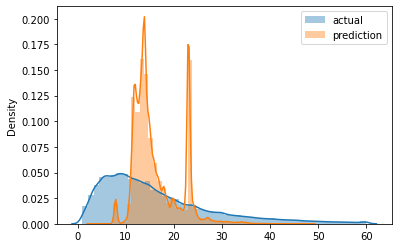

In [20]:
sns.distplot(y_train, label = 'actual')
sns.distplot(y_pred, label = 'prediction')

plt.legend()
plt.show()

### Question 6: RMSE on validation *

In [34]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [35]:
df_train = read_dataframe('../data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/fhv_tripdata_2021-02.parquet')

In [36]:
len(df_train), len(df_val)

(1109826, 990113)

In [24]:
#df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']
#df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']

In [37]:
categorical = ['PUlocationID','DOlocationID']
#categorical = ['PU_DO']
#numerical = ['trip_distance']
target = 'duration'

train_dicts = df_train[categorical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

valid_dicts = df_val[categorical].to_dict(orient = 'records')
X_val = dv.fit_transform(valid_dicts)

In [38]:
y_train = df_train[target].values
y_val = df_val[target].values

In [39]:
#1. Linear Regression

lr_2 = LinearRegression()
lr_2.fit(X_train, y_train)
y_pred = lr_2.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False)

ValueError: X has 526 features, but LinearRegression is expecting 525 features as input.